In [0]:
# mounting google drive 
from google.colab import drive
#drive.mount('/content/drive')
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [0]:
import sys
sys.path.append('/content/drive/My Drive/NLP_Project')

In [0]:
!pip install glove-python
# importing libraries
import numpy as np  
import pandas as pd 
import sys
import re            
from glove import Glove
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention import AttentionLayer
import warnings
from keras import backend as K 
from keras.initializers import Constant

     |████████████████████████████████| 266kB 5.8MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700227 sha256=80d0314fbf8faa656b813275e22d51df8c73dd0b39d373200e3beb623728ce59
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


Using TensorFlow backend.



**Reading Data** 

Read processed articles and summaries generated by DataProcessing.ipynb


In [0]:
# import json
# fp= open('/content/drive/My Drive/NLP_Project/article_highlight_Sample.json', 'r')
# content= fp.read()
# result=json.loads(content)

In [0]:
#data after preprocessing -
# print("After cleaning - ")
# print("Article: ", result[str(1)]["article"])
# print("Summary:", result[str(1)]["highlight"])
# print()

After cleaning - 
Article:  associated press published 14 11 est 25 october 2013 updated 15 36 est 25 october 2013 bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis virus late september early october state health department issued advisory exposure anyone attended five churches took communion bishop john folda pictured fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis state immunization program manager molly howell says risk low officials feel important alert people possible exposure diocese announced monday bishop john folda taking time diagnosed hepatitis diocese says contracted infection contaminated food attending conference newly ordained bishops italy last month symptoms hepatitis include fever tiredness loss appetite nausea abdominal discomfort fargo catholic diocese north dakota pictured bishop located
Summary:  bishop john folda  of nor

**Data** **Analysis**

In [0]:
df = pd.read_csv('/gdrive/My Drive/NLP_Project/Gigaword_article_highlight_Sample.csv')

In [0]:
# #Creating dataframe
# articles=[]
# summaries=[]
# d={}

# for i, obj in result.items():
#   articles.append(obj["article"])
#   summaries.append(obj["highlight"])

# d["article"]= articles
# d["summary"]= summaries

# df= pd.DataFrame.from_dict(d)

In [0]:
df.head()

,Unnamed: 0,Article,Summary
0,0,officials cabinet level fair trade commission ...,fair trade commission investigating consumer p...
1,1,five people killed woman gravely wounded follo...,colombian nightclub shootout leaves five dead
2,2,preliminary dna testing remains red army soldi...,estonia provides red army soldiers dna samples...
3,3,transocean inc. world largest offshore drillin...,transocean globalsantafe plan to combine to cr...
4,4,palestinian president mahmoud abbas make worki...,palestinian president to visit malaysia on may


In [0]:
df['summary'] = df['Summary'].apply(lambda x : "_START_ "+ x + " _END_")

**Counting numbers of words in articles and summaries**

In [0]:
article_word_count = []
summary_word_count = []

# word count
for article in df['Article']:
      article_word_count.append(len(article.split()))

for summary in df['summary']:
      summary_word_count.append(len(summary.split()))

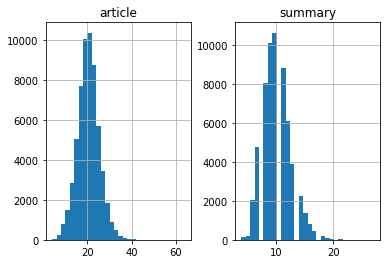

In [0]:
import matplotlib.pyplot as plt
length_df = pd.DataFrame({'article':article_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [0]:
lengths_articles = pd.DataFrame(article_word_count, columns=['counts'])
lengths_summaries = pd.DataFrame(summary_word_count, columns=['counts'])

print("Articles:")
print(lengths_articles.describe())

print("\nSummaries:")
print(lengths_summaries.describe())

Articles:
             counts
count  60000.000000
mean      19.922083
std        4.906283
min        4.000000
25%       17.000000
50%       20.000000
75%       23.000000
max       64.000000

Summaries:
             counts
count  60000.000000
mean      10.168550
std        2.419278
min        4.000000
25%        8.000000
50%       10.000000
75%       12.000000
max       27.000000


In [0]:
# Inspect the length of articles
print(np.percentile(lengths_articles.counts, 90))
print(np.percentile(lengths_articles.counts, 95))
print(np.percentile(lengths_articles.counts, 99))

26.0
28.0
33.0


In [0]:
# Inspect the length of summaries
print(np.percentile(lengths_summaries.counts, 90))
print(np.percentile(lengths_summaries.counts, 95))
print(np.percentile(lengths_summaries.counts, 99))

13.0
15.0
17.0


~90 percentile of the articles contain less than 653 words and ~90 percentile of summaries contain less than 74 words

We use this data to set a reasonable value for **max_len_text** and **max_len_summary**

In [0]:
max_len_text= 33
max_len_summary= 15

**Word Embeddings**

We use pre-trained word embeddings from GLoVe 

These word embeddings were generated by training model on Wikipedia 2014 and Gigaword Dataset 

Vocabulary Size: 400,000 words 

Embedding vector dimension: 50


In [0]:
glove= Glove()
model= glove.load_stanford('/gdrive/My Drive/NLP_Project/gloveEng/glove.6B.300d.txt')

Printing sample word vectors

In [0]:
model.word_vectors[model.dictionary['woman']]

array([-0.51821  , -0.13809  , -0.41185  , -0.13133  ,  0.0035659,
       -0.31205  , -0.31242  , -0.43538  , -0.27017  , -1.1338   ,
        0.19282  , -0.23786  ,  0.0028892, -0.027078 ,  0.14747  ,
       -0.051265 ,  0.089021 , -0.12337  , -0.40892  , -0.39197  ,
       -0.5665   ,  0.40684  , -0.057313 ,  0.18613  , -0.33095  ,
       -0.25243  ,  0.33452  , -0.23104  , -0.0099149,  0.24269  ,
       -0.57504  ,  0.30122  , -0.33779  , -0.294    , -0.80202  ,
        0.44674  , -0.40296  , -0.21026  ,  0.1072   ,  0.53937  ,
        0.63971  , -0.3154   , -0.082537 , -0.038314 , -0.058821 ,
        0.11235  ,  0.50928  ,  0.14656  , -0.18988  ,  0.24132  ,
       -0.038442 ,  0.071418 ,  0.38471  ,  0.10584  , -0.52786  ,
       -0.057574 ,  0.13771  , -0.48613  ,  0.62553  , -0.3308   ,
       -0.065539 ,  0.1791   ,  0.62746  ,  0.087208 , -0.60422  ,
       -0.64595  , -0.2389   , -0.1585   , -0.07948  , -0.037848 ,
       -0.205    , -0.44504  , -0.21127  , -0.0026664, -0.0080

Printing words with similar word embeddings

In [0]:
print(model.most_similar('woman'))

[('girl', 0.7296419112178933), ('man', 0.6998663379619018), ('mother', 0.6899437807604597), ('she', 0.6433226707219909)]


In [0]:
# creating embedding dictionary
embeddings_index = {}

for word in model.dictionary:
  embedding = model.word_vectors[model.dictionary[word]]
  embeddings_index[word] = embedding
  

In [0]:
print(len(embeddings_index["the"]))

300


**Split Data for training and testing**

In [0]:
from sklearn.model_selection import train_test_split

x_tr,x_test,y_tr,y_test = train_test_split(df['Article'],df['summary'],test_size=0.1,random_state=0,shuffle=True) 

x_tr,x_val,y_tr,y_val = train_test_split(x_tr,y_tr,test_size=0.1,random_state=0,shuffle=True) 


In [0]:
print('Training data: ', len(x_tr))
print('Validation data: ', len(x_val))
print('Testing data:', len(x_test))

Training data:  48600
Validation data:  5400
Testing data: 6000


**Tokenize Data, create vocabulary**

Article Tokenizer

In [0]:
before_sample=x_tr[0]
# Tokenizer library in keras that maps words to integers, integers to words
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))
x_voc_size   =  len(x_tokenizer.word_index) +1

# convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

# padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')
after_sample=x_tr[0]

In [0]:
print("Aricle Before: \n"+str(before_sample[0:250]))
print()
print("Article After: \n"+str(after_sample[0:250]))

Aricle Before: 
officials cabinet level fair trade commission lrb ftc rrb said friday formed ad hoc group investigate whether manipulation commodity prices traders local market .

Article After: 
[ 243  139 3319    2  304 2550 1644 1208 1869  502 2106  245  304  410
  154   29 1528  331   66 1033 1705  113    1 2686    3   29  140  945
  606    0    0    0    0]


Summary Tokenizer

In [0]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))
y_voc_size  =   len(y_tokenizer.word_index) +1

# same for summaries
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

In [0]:
# create embedding matrix to be used in model
embedding_dim= 300

x_embedding_matrix= np.zeros((x_voc_size, embedding_dim))

for word, i in x_tokenizer.word_index.items():
  if i> x_voc_size:
    continue
  embedding_vector= embeddings_index.get(word)

  if embedding_vector is not None:
    x_embedding_matrix[i]= embedding_vector

In [0]:
# embedding matrix for decoder to be used in model
y_embedding_matrix= np.zeros((y_voc_size, embedding_dim))

for word, i in y_tokenizer.word_index.items():
  if i> y_voc_size:
    continue
  embedding_vector= embeddings_index.get(word)

  if embedding_vector is not None:
    y_embedding_matrix[i]= embedding_vector

In [0]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(40792, 300)
(24277, 300)


**Build Model**


In [0]:
latent_dim = 300 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,embeddings_initializer= Constant(x_embedding_matrix), trainable=False)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
encoder_output1, forward_h, forward_c, backward_h, backward_c = encoder_lstm1(enc_emb)
"""
state_h1 = Concatenate()([forward_h, backward_h])
state_c1 = Concatenate()([forward_c, backward_c])
encoder_states = [state_h1, state_c1]
"""
#LSTM 2 
# encoder output 1 is fed as input to the next lstm
encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_output1)
"""
state_h2 = Concatenate()([forward_h2, backward_h2])
state_c2 = Concatenate()([forward_c2, backward_c2])
encoder_states = [state_h2, state_c2]
#encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 
"""
#LSTM 3 
# encoder output 2 fed as input to next lstm 
encoder_lstm3=Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_output3, forward_h3, forward_c3, backward_h3, backward_c3 = encoder_lstm3(encoder_output2)
"""
state_h3 = Concatenate()([forward_h3, backward_h3])
state_c3 = Concatenate()([forward_c3, backward_c3])
encoder_states3 = [state_h3, state_c3]
#encoder_output3, state_h, state_c= encoder_lstm3(encoder_output2) 
"""
#LSTM 4
encoder_lstm4=Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_outputs, forward_h4, forward_c4, backward_h4, backward_c4 = encoder_lstm2(encoder_output3)
state_h = Concatenate()([forward_h4, backward_h4])
state_c = Concatenate()([forward_c4, backward_c4])
encoder_states = [state_h, state_c]
print(state_h.shape)
print(state_c.shape)
#encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3) 


(None, 600)
(None, 600)


In [0]:
# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer=  Embedding(y_voc_size, latent_dim,embeddings_initializer= Constant(y_embedding_matrix), trainable=False)
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM1
# Using encoder_states as decoder's initial state
decoder_lstm1 = LSTM(2*latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm1(dec_emb,initial_state=encoder_states) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method AttentionLayer.call of <attention.AttentionLayer object at 0x7fe24b9f8c88>>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method AttentionLayer.call of <attention.AttentionLayer object at 0x7fe2

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5198644503774624869
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3256129796683126582
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7712939936977623283
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6203480386392498484
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# early stopping 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 300)      12237600    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 33, 600), (N 1442400     embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 33, 600), (N 2162400     bidirectional[0][0]              
                                                                 bidirectional_2[0][0]        

In [0]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=8,batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]),callbacks = [es])


Epoch 1/8
380/380 [==============================] - 217s 572ms/step - loss: 4.4469 - val_loss: 3.8399
Epoch 2/8
380/380 [==============================] - 217s 570ms/step - loss: 3.8045 - val_loss: 3.5300
Epoch 3/8
380/380 [==============================] - 216s 567ms/step - loss: 3.4882 - val_loss: 3.3750
Epoch 4/8
380/380 [==============================] - 216s 568ms/step - loss: 3.2610 - val_loss: 3.3002
Epoch 5/8
380/380 [==============================] - 216s 568ms/step - loss: 3.0706 - val_loss: 3.2606
Epoch 6/8
380/380 [==============================] - 216s 569ms/step - loss: 2.8914 - val_loss: 3.2317
Epoch 7/8
380/380 [==============================] - 216s 568ms/step - loss: 2.7174 - val_loss: 3.2451
Epoch 00007: early stopping


Plotting training and validation error to check over-fitting 

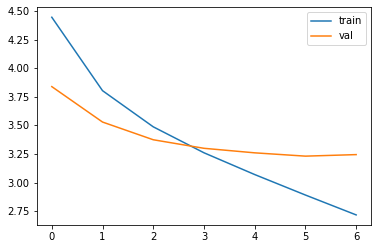

In [0]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='val') 
pyplot.legend()
pyplot.show()

In [0]:
from tensorflow.keras.models import load_model
#model = load_model('/content/drive/My Drive/my_model3.h5',custom_objects={'AttentionLayer': AttentionLayer})
model.save('/gdrive/My Drive/NLP_Project/gigaword_baseline_attn.h5')  # creates a HDF5 file 'my_model.h5'
#path = '/content/drive/My Drive/my_model4.h5'
#model.save(path)

In [0]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [0]:
len(reverse_source_word_index)

40791

In [0]:
import copy
#2 ideas : threshold value if less, remove and if end token found, remove and store in another list and then merge at the end

def beam_search(encoder_model,decoder_model, src_input, k, sequence_max_len):

    e_out, e_h, e_c = encoder_model.predict(src_input)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    start = True
    
    #print(k_beam)
    # l : point on target sentence to predict
    all_k_beams = [[[],1]]
    load_hidden={}
    end_sentence = []
    for l in range(sequence_max_len):

        if(start==True):

          start=False
          output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
          possible_k = output_tokens[0, -1, :].argsort()[-k:][::-1]
          #print("Possible k in start: "+str((possible_k)))
          dummy_list = []
          begin=True
          for cand in all_k_beams:
            
            for curr_k in possible_k:
              #print("Cand: "+str(cand)+" curr_k: "+str(curr_k))
              #print(cand[0]+[curr_k])
              #print(cand[1]+np.log(output_tokens[0, -1, :][curr_k]))
              curr = [cand[0]+[curr_k],cand[1]-np.log(output_tokens[0, -1, :][curr_k])]
              
              dummy_list.append(curr)
              if(begin==True):
                #target_seq = np.zeros((1,1))
                #target_seq[0, 0] = curr_k
                load_hidden[curr_k] = [h,c]
            begin=False
          all_k_beams = dummy_list[:]
          #print(all_k_beams)
          prev_target_seq = copy.deepcopy(possible_k)
          #print("load_hidden: "+str(load_hidden.keys()))
        else:
          #print("l is: "+str(l))
          #print("In else, prev target seq: "+str(prev_target_seq))
          for target_seq1 in prev_target_seq:
            #print("Prev index: "+str(target_seq1))
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = target_seq1

            output_tokens, h, c = decoder_model.predict([target_seq] + [e_out,load_hidden[target_seq1][0],load_hidden[target_seq1][1]])

            possible_k = output_tokens[0, -1, :].argsort()[-k:][::-1]
            #print("Possible k not in start: "+str((possible_k)))

            dummy_list = []
            begin = True
            for cand in all_k_beams:
              for curr_k in possible_k:
                if(cand[0][-1]==target_seq1 and len(cand[0])==l):
                  #print("Here I am")
                  #print("Looking at cand: "+str(cand[0]))
                  ended=False
                  curr = [cand[0]+[curr_k],cand[1]-np.log(output_tokens[0, -1, :][curr_k])]
                  if(curr_k in reverse_target_word_index):
                    sampled_token = reverse_target_word_index[curr_k]
                    if(sampled_token=='end'):
                      end_sentence.append(curr)
                      ended=True
                  if(ended==False):
                    dummy_list.append(curr)
                if(begin==True):
                  #target_seq = np.zeros((1,1))
                  #target_seq[0, 0] = curr_k
                  load_hidden[curr_k] = [h,c]
              begin=False
            all_k_beams +=dummy_list
            #print(all_k_beams)
            prev_target_seq = copy.deepcopy(possible_k)
        
        # top k
    #print(end_sentence)
    all_k_beams += end_sentence
    all_k_beams.sort(key=lambda r:r[1])
    k_beam = all_k_beams[-k:]
    #k_beam = k_beam[::-1]
    return k_beam

In [0]:
# Inference Phase 

"""
After training, the model is tested on new source sequences
for which the target sequence is not known 
setting up inference architecture for it 
"""

# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(2*latent_dim,))
decoder_state_input_c = Input(shape=(2*latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm1(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
"""
decoder_outputs3, state_h2, state_c2 = decoder_lstm2(decoder_outputs2)
decoder_outputs4, state_h2, state_c2 = decoder_lstm3(decoder_outputs3)
decoder_outputs5, state_h2, state_c2 = decoder_lstm4(decoder_outputs4)
"""
#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs] + [state_h2, state_c2])


In [0]:
def decode_sequence(input_seq, search_strat):
    # Encode the input as state vectors.

    if(search_strat =="Beam"):
      decoded_sentence = beam_search(encoder_model,decoder_model, input_seq, 3, 50)
    else:
      e_out, e_h, e_c = encoder_model.predict(input_seq)

      # Generate empty target sequence of length 1.
      target_seq = np.zeros((1,1))

      # Chose the 'start' word as the first word of the target sequence
      target_seq[0, 0] = target_word_index['start']

      stop_condition = False
      decoded_sentence = ''
      
      while not stop_condition:
          output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

          # Sample a token
          sampled_token_index = np.argmax(output_tokens[0, -1, :])

          if sampled_token_index in reverse_target_word_index:
            sampled_token = reverse_target_word_index[sampled_token_index]
          else:
            sampled_token="UNK"
            
          if(sampled_token!='end'):
              decoded_sentence += ' '+sampled_token

          # Exit condition: either hit max length or find stop word.
          if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
              stop_condition = True

          # Update the target sequence (of length 1).
          target_seq = np.zeros((1,1))
          target_seq[0, 0] = sampled_token_index

          # Update internal states
          e_h, e_c = h, c
    
    return decoded_sentence


In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [0]:
def get_sentence(model_summary):
  all_Sentence = []
  for int_sent in model_summary:
    sent = int_sent[0]
    decoded_sentence= ''
    for sampled_token_index in sent:
      if sampled_token_index in reverse_target_word_index:
        sampled_token = reverse_target_word_index[sampled_token_index]
      else:
        sampled_token="UNK"
            
      if(sampled_token!='end'):
        decoded_sentence += ' '+sampled_token
      else:
        print("broken")
        break
    #print(str(decoded_sentence)+ " , "+str(int_sent[1]))
    all_Sentence.append([decoded_sentence,int_sent[1]])
  return all_Sentence 


In [0]:
refrence_summary = seq2summary(y_tr[4])
search_strat = "Greedy" #"Beam"
model_summary = decode_sequence(x_tr[4].reshape(1,max_len_text),search_strat)

print("Reference summary: "+str(refrence_summary))
if(search_strat=="Greedy"):
  print("Predicted summary: "+str(model_summary))
else:
  all_s=get_sentence(model_summary)
  for pred_s in all_s:
    print("Predicted summary: "+str(pred_s))

Reference summary: basque separatists cease fire warn of violence 
Predicted summary:  basque separatists in eta to be cease fire


In [0]:
!pip install rouge
from rouge import Rouge

In [1]:
print("Writing results to file")
fp = open("/gdrive/My Drive/NLP_Project/Gigaword_Model_summaries_baseline_plus_attention_try_3.txt",'w')
for i in range(500):
  fp.write("Article:" + seq2text(x_val[i]))
  originalSummary = seq2summary(y_val[i])
  fp.write("\nOriginal summary:" + originalSummary)
  predictedSummary = decode_sequence(x_val[i].reshape(1,max_len_text),"greedy")
  fp.write("\nPredicted summary:" + predictedSummary)
  rouge = Rouge()
  scores = rouge.get_scores(predictedSummary, originalSummary) 
  fp.write(str(scores[0]['rouge-1']['f']))
  fp.write(str(scores[0]['rouge-l']['f']))
  fp.write("\n")
fp.close()

Writing results to file


In [0]:
fp= open('/content/drive/My Drive/NLP_Project/Gigaword_Model_summaries_baseline_plus_attention.txt', 'r')
content= fp.readlines()


In [0]:
results = {}
pos =0
while(pos < len(content)):
  article = content[pos].split(":")
  value = {}
  results[article[1].rstrip()] = value
  pos += 1
  orig = content[pos].split(":")
  value["original"] = orig[1].rstrip()
  pos += 1
  pred = content[pos].split(":")
  second = pred[1]
  important = second.split('0')
  value["predicted"] = important[0].rstrip()
  pos += 1

In [0]:
!pip install rouge

In [2]:
count = len(results)
sum_rouge_1 =0
sum_rouge_2 =0
sum_rouge_lcs =0
highest_rouge_1 =0
highest_rouge_2 =0
highest_rouge_lcs =0
from rouge import Rouge 
for key in results:
  value = results[key]
  rouge = Rouge()
  # print(value["predicted"])
  # print(value["original"])
  scores = rouge.get_scores(value["predicted"], value["original"])
  # print(scores)
  sum_rouge_1 += scores[0]['rouge-1']['f']
  sum_rouge_2 += scores[0]['rouge-2']['f']
  sum_rouge_lcs += scores[0]['rouge-l']['f']
  if(scores[0]['rouge-1']['f'] > highest_rouge_1):
    highest_rouge_1  = scores[0]['rouge-1']['f']
  if(scores[0]['rouge-2']['f'] > highest_rouge_2):
    highest_rouge_2  = scores[0]['rouge-2']['f']
  if(scores[0]['rouge-l']['f'] > highest_rouge_lcs):
    highest_rouge_lcs  = scores[0]['rouge-l']['f']

average_rouge_1 = sum_rouge_1/count
average_rouge_2 = sum_rouge_2/count
average_rouge_lcs = sum_rouge_lcs/count
print("Average rouge 1 Score : " + str(average_rouge_1))
print("Average rouge 2 Score : " + str(average_rouge_2))
print("Average rouge lcs Score : " + str(average_rouge_lcs))
print("\n")
print("Highest Rouge 1 score : " + str(highest_rouge_1))
print("Highest Rouge 2 score : " + str(highest_rouge_2))
print("Highest Rouge lcs score : " + str(highest_rouge_lcs))


Average rouge 1 Score : 0.2301
Average rouge 2 Score : 0.4555
Average rouge lcs Score : 0.1621


Highest Rouge 1 score : 0.9999
Highest Rouge 2 score : 0.9999
Highest Rouge lcs score : 0.9999


In [0]:
!pip3 install --upgrade nltk 
from nltk.translate import AlignedSent, Alignment
from nltk.translate.meteor_score import meteor_score

In [0]:
import nltk
nltk.download('wordnet')

In [0]:
content= fp.readlines()
references_english = []
predicted_english = []
pos =0
while(pos < len(content)):
  pos += 2
  orig = content[pos].split(":")
  references_english.append(orig[1])
  pos += 1
  pred = content[pos].split(":")
  predicted_english.append(pred[1])
  pos += 1

In [3]:
total_meteor = 0.0
n = 0 
for i in range(len(references_english)):
  total_meteor += round(meteor_score([references_english[i]], predicted_english[i]),4)
  n+=1
print("Average score")
print("\n")
print(total_meteor/n)

Average score


18.05
